In [53]:
import numpy as np
import time
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize

# Load Data

In [54]:
X = np.load("X_feat_mat_erp.npy")
y = np.load("y_label_vect_erp.npy")

In [55]:
print('X.shape={}, y.shape={}'.format(X.shape, y.shape))

X.shape=(102, 6), y.shape=(102,)


### Normalize Data

In [56]:
# Shift to zero mean and normalize y
y = y-1
y

array([ 0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
        0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  0.,
        1.,  1.,  1.,  1.,  0.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
        1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,  0.,
        0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,
        1.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,
        0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  1.])

In [57]:
# Normalize X
X = normalize(X)
X.shape

(102, 6)

### Dimensionality Reduction

In [58]:
# Parameter
var_desired = 0.95

# PCA
pca = PCA(n_components=X.shape[1]-1)
pca.fit(X)
 
print('pca.explained_variance_ratio_:\n',pca.explained_variance_ratio_)    

var_sum = pca.explained_variance_ratio_.sum()
var = 0
for n, v in enumerate(pca.explained_variance_ratio_):
    var += v
    if var / var_sum >= var_desired:
        pca_trans = PCA(n_components=n+1)
        X_pca = pca_trans.fit_transform(X)
        print("Reached Variance: {:1.3f}".format(var/var_sum))
        break
        
print("X_pca.shape: ",X_pca.shape)

pca.explained_variance_ratio_:
 [ 0.51117888  0.33326508  0.08226043  0.03397359  0.02606136]
Reached Variance: 0.974
X_pca.shape:  (102, 4)


### Split Data

In [59]:
split_n = 90
X_train, X_test = X_pca[:split_n], X_pca[split_n:]
y_train, y_test = y[:split_n], y[split_n:]

### Plot data

In [60]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

Preserved Varaince: 0.844


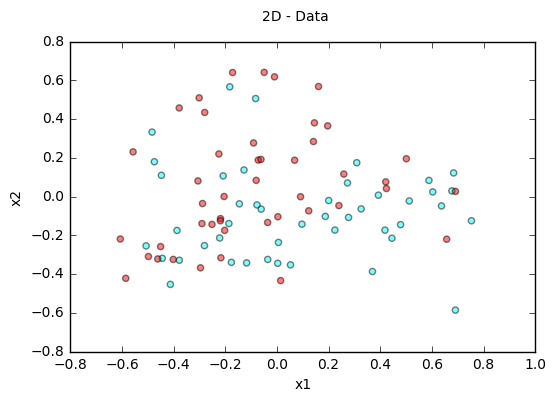

In [61]:
# 2D Plot
if X_train.shape[1] != 2:
    # PCA 
    pca_2comp = PCA(n_components=2)
    X_2comp = pca_2comp.fit_transform(X)
    
# Plot
colors_data = ['red','cyan']
fig = plt.figure()
fig.suptitle('2D - Data')
ax = fig.add_subplot(1,1,1)
ax.scatter(X_train.T[0], X_train.T[1], alpha=0.5,
           c=y_train, cmap=mpl.colors.ListedColormap(colors_data))
ax.set_xlabel('x1')
ax.set_ylabel('x2')

print("Preserved Varaince: {:1.3f}".format(pca_2comp.explained_variance_ratio_.sum()))

Preserved Varaince: 0.927


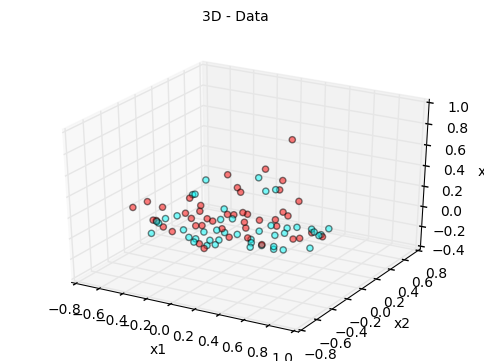

In [62]:
# 3D Plot
if X_train.shape[1] != 3:
    # PCA 
    pca_3comp = PCA(n_components=3)
    X_3comp = pca_3comp.fit_transform(X)
    
# Plot
colors_data = ['red','cyan']
fig = plt.figure()
fig.suptitle('3D - Data')
ax = fig.add_subplot(1,1,1, projection='3d')
ax.scatter(X_train.T[0], X_train.T[1], X_train.T[2], alpha=0.5,
           c=y_train, cmap=mpl.colors.ListedColormap(colors_data))
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('x3')

print("Preserved Varaince: {:1.3f}".format(pca_3comp.explained_variance_ratio_.sum()))

# Classifiers

In [63]:
# Print results of classifier
def results(y, y_):
    # Results
    n_mclf = len(np.nonzero(y-y_)[0])
    rate_mclf = n_mclf / len(y)
    print('Misclassifications = {} from {} total samples. MCLF Rate = {}'.format(
        n_mclf, len(y), rate_mclf))

# SciKit Random Forest

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
clf_rf = RandomForestClassifier(n_estimators=100)
clf_rf.fit(X_train, y_train)

# Prediction
y_rf = clf_rf.predict(X_test)
results(y_test, y_rf)

Misclassifications = 1 from 12 total samples. MCLF Rate = 0.08333333333333333


# SciKit Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegression

In [67]:
# Train
clf_lr = LogisticRegression(C=100)
clf_lr.fit(X_train, y_train)
# Predict
y_lr = clf_lr.predict(X_test)
results(y_test, y_lr)

Misclassifications = 3 from 12 total samples. MCLF Rate = 0.25


# MLP Tensorflow

In [68]:
import tensorflow as tf

In [99]:
Y_train = y_train.reshape(-1,1)
Y_test = y_test.reshape(-1,1)

# Computing Parameter
NUM_THREADS = 10
# Visualization Parameter
display_step = 100
# Learning Parameters
learning_rate = 0.1
training_epochs = 100
dropout_rate = 0.5
converg_thresh = 0.001     # threshold of improvement between accuracy of last 2 epochs
total_len = X_train.shape[0]

# Network Parameters
n_input = X_train.shape[1]
n_hidden_1 = 5    # 1st layer number of features
n_hidden_2 = 1    # 2nd layer number of features
n_output = Y_train.shape[1]


# Create nodes for the input data and target output classes
x = tf.placeholder(tf.float32, shape=[None, X_train.shape[1]]) # first dimension not fixed (depends on batch size)
y = tf.placeholder(tf.float32, shape=[None, Y_train.shape[1]])    
# Dropout
keep_prob = tf.placeholder(tf.float32)

# Create model
def mlp_model(x, weights, biases):
    # 1. Hidden layer
    layer_1 = tf.add(tf.matmul(x, weights['w1']), biases['b1'])
    layer_1 = tf.tanh(layer_1) 
    # 2. Hidden layer
    layer_2 = tf.add(tf.matmul(layer_1, weights['w2']), biases['b2'])
    layer_2 = tf.tanh(layer_2)
    # Output layer with linear activation
    layer_out = tf.add(tf.matmul(layer_2, weights['w_out']), biases['b_out'])
    layer_out = tf.sigmoid(layer_out)
    return layer_out

# Store layers weight & bias
weights = { 
    'w1': tf.Variable(tf.random_normal([n_input, n_hidden_1], 0, 0.1)),
    'w2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2], 0, 0.1)),
    'w_out': tf.Variable(tf.random_normal([n_hidden_2, n_output], 0, 0.1))
}
biases = {
        'b1': tf.Variable(tf.random_normal([n_hidden_1], 0, 0.1)),
        'b2': tf.Variable(tf.random_normal([n_hidden_2], 0, 0.1)),
        'b_out': tf.Variable(tf.random_normal([n_output], 0, 0.1))
}

# Construct model
y_pred = mlp_model(x, weights, biases)

# Define loss and optimizer
#cost = tf.reduce_mean(tf.square(tf.transpose(y_pred)-y))
cost = tf.reduce_mean(tf.square(y_pred-y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

#
# Train and Evaluate the Model
#

# Start interactive session
sess = tf.InteractiveSession(config=tf.ConfigProto(intra_op_parallelism_threads=NUM_THREADS))

# loss function
correct_prediction = tf.equal(tf.argmax(y_pred,1), tf.argmax(y,1))
# result
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# start sesseion
sess.run(tf.global_variables_initializer())
# training
train_accuracy_list = [0]
t0 = time.time()

for epoch in range(training_epochs):
    # Train
    optimizer.run(feed_dict={x:X_train, y:Y_train, keep_prob:dropout_rate})
    # Show update 
    if epoch % display_step == 0:
        train_accuracy_list.append(accuracy.eval(feed_dict={x:X_train, y:Y_train, keep_prob:1.0}))
        improvement = abs(train_accuracy_list[-2] - train_accuracy_list[-1])
        print("Epoch %d, training accuracy %g, improvement %.5f (%.0f sec)"%(
                epoch, train_accuracy_list[-1], improvement, time.time()-t0))
        t0 = time.time()
        # Check if converged
#        if train_accuracy_list[-1] == 1 or improvement <= converg_thresh:
#            print("Converged!")
#            break

print("Test accuracy %g"%accuracy.eval(
        feed_dict={x: X_test, y: Y_test, keep_prob: 1.0}))


Epoch 0, training accuracy 1, improvement 1.00000 (0 sec)
Test accuracy 1


In [100]:
# Test net
y_tf = sess.run(y_pred, feed_dict={x: X_test})

# Misclassification
n_mclf = len(np.nonzero(np.round(y_tf) - Y_test)[0])
mclf_rate = n_mclf / len(Y_test)

# MSE
mse = ((y_tf - Y_test) ** 2).mean()

print('Test: n_mclf = {} / {} (mclf_rate={:.3f}), mse = {:.3f}'.format(n_mclf, len(Y_test), mclf_rate, mse))

Test: n_mclf = 2 / 12 (mclf_rate=0.167), mse = 0.149


In [98]:
np.hstack((y_tf, Y_test))

array([[ 0.22644906,  0.        ],
       [ 0.22644906,  0.        ],
       [ 0.22644906,  1.        ],
       [ 0.22644906,  0.        ],
       [ 0.761621  ,  1.        ],
       [ 0.22644906,  0.        ],
       [ 0.67082191,  1.        ],
       [ 0.22644906,  0.        ],
       [ 0.761621  ,  1.        ],
       [ 0.22644906,  0.        ],
       [ 0.22644952,  1.        ],
       [ 0.761621  ,  1.        ]])

# NumPy MLP

In [72]:
class Neural_Network:
    def __init__(self, n_inpt, n_hidden, n_output, hid_transfer='tanh', out_transfer='sigmoid'):
        self.w0 = 2 * np.random.random((n_inpt, n_hidden))
        self.w1 = 2 * np.random.random((n_hidden, n_output))
        self.hid_transfer = hid_transfer
        self.out_transfer = out_transfer
        self.loss = []


    def transfer_function(self, fct_type, x, deriv=False):
        if fct_type == 'sigmoid':
            if deriv == True:
                return x * (1 - x)
            return 1 / (1 + np.exp(-x))
        elif fct_type == 'tanh':
            if deriv == True:
                return 1-x*x
            return np.tanh(x)
        elif fct_type == 'linear':
            if deriv == True:
                return 1
            return x
        elif fct_type == 'rectifier':
            if deriv == True:
                return (x > 0.)
            return x * (x > 0.)


    def forward_pass(self, X):
        l0 = X
        l1 = self.transfer_function(fct_type=self.hid_transfer, x=np.dot(l0, self.w0))
        l2 = self.transfer_function(fct_type=self.out_transfer, x=np.dot(l1, self.w1))
        return (l0,l1,l2)


    def train(self, X, y, learn_rate=0.1, momentum=0.9, epochs=10000):
        # initialize momentum
        m1 = 0
        m0 = 0

        for epoch in range(epochs):
            (l0,l1,l2) = self.forward_pass(X)

            # error at the output (signed) 
            residual = y - l2
            # sum of squared errors
            self.loss.append(sum(i**2 for i in residual))

            # compute output delta
            l2_delta = residual * self.transfer_function(fct_type=self.out_transfer, 
                                                         x=l2, deriv=True)
            # back-propagate the output delta to the hidden units
            l1_error = l2_delta.dot(self.w1.T)
            # compute the delta at the hidden units
            l1_delta = l1_error * self.transfer_function(fct_type=self.hid_transfer, 
                                                         x=l1, deriv=True)
            # comnpute momentum
            m1 = l1.T.dot(l2_delta) + momentum*m1
            m0 = l0.T.dot(l1_delta) + momentum*m0
            # update weights
            self.w1 += learn_rate * m1
            self.w0 += learn_rate * m0

            # evaluate progress
            if epoch > 1 and epoch % 100000 == 0:
                print("iteration {}".format(epoch))

In [103]:
# network parameter
epochs = 100
learning_rate = 0.01
momentum = 0.9
n_hidden_neurons = 10

# init network
net = Neural_Network(X_train.shape[1], n_hidden_neurons, Y_train.shape[1], 
                     hid_transfer='tanh', out_transfer='sigmoid')
# train network
net.train(X_train, Y_train, learning_rate, momentum, epochs)

In [104]:
# test network
l0,l1,l2 = net.forward_pass(X_test)
# evaluate results
mse =  ((l2 - Y_test) ** 2).mean()
n_mclf = len(np.nonzero(Y_test - np.round(l2))[0])
mclf_rate = n_mclf / len(Y_test)
print('Test: n_mclf = {} / {} (mclf_rate={:.3f}), mse = {:.3f}'.format(n_mclf, len(Y_test), mclf_rate, mse))

Test: n_mclf = 3 / 12 (mclf_rate=0.250), mse = 0.113


# - SVM (SciKit Learn)

In [75]:
from sklearn import svm

In [76]:
clf_svm = svm.SVC()
clf_svm.fit(X_train, y_train)  
y_svm = clf_svm.predict(X_test)

results(y_test, y_svm)

Misclassifications = 3 from 12 total samples. MCLF Rate = 0.25
